# [Amet Vikram]
# Programming Exercise \#3
---

# Preamble

In [ ]:
# optional code cell when using Google Colab with Google Drive

# remove the docstring comment block below in order to mount Google Drive
'''
# mount Google Drive in Google Colab
from google.colab import drive
drive.mount('/content/drive')

# change directory using the magic command %cd
### replace [MY PATH] below with your own path in Google Drive ###
### %cd /content/drive/My\ Drive/[MY PATH] ###
'''

In [1]:
# import relevant Python libraries

import numpy as np
import pandas as pd
from scipy import stats as sps
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, Latex

# **1. Noise Level Classification Using Plug-in Classifiers**

## 1.1

### (a)

In [2]:
df = pd.read_csv("NoiseClassificationTrainingData.csv")

# Applying groupby on df based on "ClassLabel"
groups = df.groupby("ClassLabel")

# Getting only "NoiseLevel" column for further processing
grouped = groups["NoiseLevel"]

# print("Total number of classes:",len(grouped.groups))
# print("\n")
# print("The label name of all classes:", grouped.groups.keys())
# print("\n")

# Getting the class label for all classes
class_keys = grouped.groups.keys()

# nj vector which stores count of individual classes
n_j = grouped.count()

# n_total scaler value which stores the total count sum of all classes
n_total = n_j.sum()

# nj_sum vector which stores the individual sum of all classes
nj_sum = grouped.sum()

# mean_j vector which stores the individual mean of all classes
mean_j = nj_sum / n_j
print("For 'ClassLabel' 0, 1, 2 :-")
print("The individual mean of all classes in same order are :",mean_j.values)
print("\n")

# Now here we will apply formula for common covariance matrix but
# since we have only one feature vector the equation will reduce to 
# calculating simple scaler common variance. Although we will use variable M
# as we have unknown means in the equation for each class distribution.
total_sum = 0
M = 3
for key in class_keys:
    s = np.square(grouped.get_group(key) - mean_j[key])
    total_sum += s.sum()
common_variance = total_sum / (n_total - M)

print("The common variance for three classes is:",common_variance)

For 'ClassLabel' 0, 1, 2 :-
The individual mean of all classes in same order are : [44.65630955 55.27723181 64.88690064]


The common variance for three classes is: 12.08593207516877


### (b)

After investigating the **np.var()** function, it observed that by default np.var() function gives **MLE estimate** of the variance for a given sample data points. As per the definition of the np.var() function in the numpy documentation, we can see that the parameter **ddof** is the **"Delta Degrees of Freedom"** and is the divisor used in the calculation is as ``N - ddof``, where ``N`` represents the number of elements. By default **ddof** is zero. Therefore, it is clear that by default **np.var()** gives the **biased MLE estimate** of variance. To get the unbiased variance we have to give the parameter **ddof** as 1.

## 1.2

### (a)

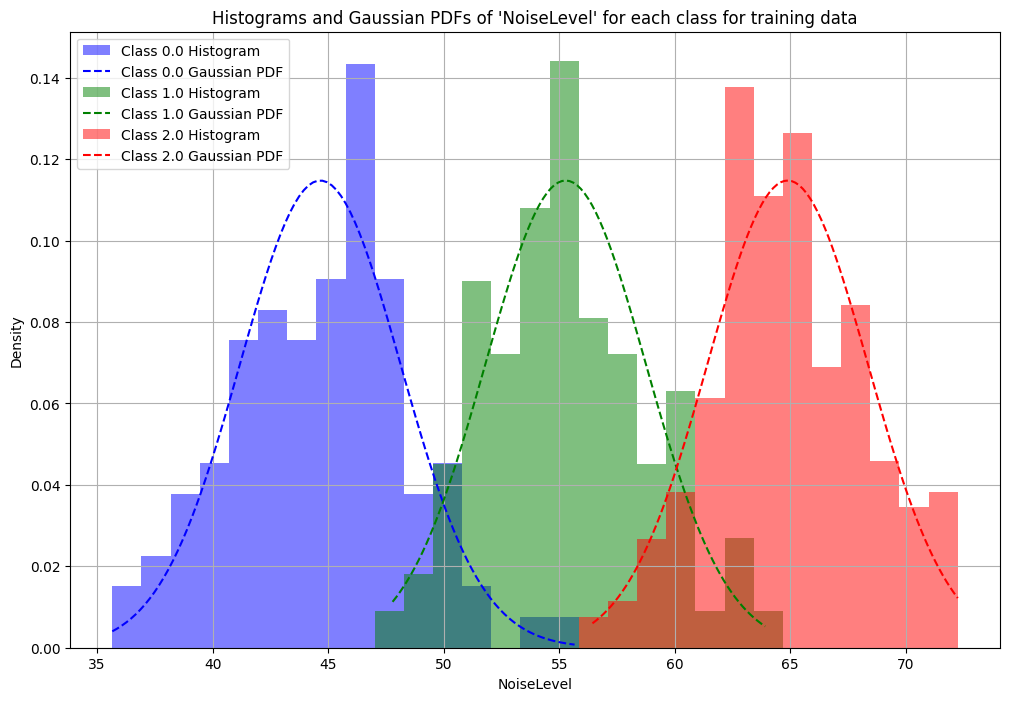

In [3]:
plt.figure(figsize=(12, 8))

# Defining bins and color scheme
bins = np.linspace(df["NoiseLevel"].min(), df["NoiseLevel"].max(), 30)
color = ["blue", "green", "red"]

for key in class_keys:
    plt.hist(grouped.get_group(key), bins=bins, density=True, alpha=0.5, color=color[int(key)], label="Class {} Histogram".format(key))
    x_values = np.linspace(grouped.min()[key], grouped.max()[key], 100)
    plt.plot(x_values, 
             sps.norm.pdf(x_values, mean_j[key], np.sqrt(common_variance)), color=color[int(key)], linestyle='--', label="Class {} Gaussian PDF".format(key)
    )

plt.xlabel("NoiseLevel")
plt.ylabel("Density")
plt.title("Histograms and Gaussian PDFs of 'NoiseLevel' for each class for training data")
plt.legend()
plt.grid(True)
plt.show()

### (b)

Based on the histograms and the overlayed Gaussian PDFs, we can conclude that the assumption of common variance but different means is a reasonable assumption for the given sample "NoiseLevel" data points. As we can see that for each class, the gaussian pdf is covering the maximum portion of histogram, although there are few outliers which does not fit into the pdf. Overall, we can conclude that the gaussian with different means and common variance is a valid pdf for the data points.

## 1.3

In [4]:
# Calculates prior probabilities based on the count of individual classes
prior_prob = n_j / n_total
print("For 'ClassLabel' 0, 1, 2 :-")
print("The individual prior probabilities of all classes in same order are :",prior_prob.values)

For 'ClassLabel' 0, 1, 2 :-
The individual prior probabilities of all classes in same order are : [0.2625 0.22   0.5175]


## 1.4

In [5]:
# Calculates value of gaussian probability function for given 
# value of x , given mean and given variance
def plugin_gaussian_function(x, mean, variance):
    p = (np.square(x - mean) / variance) * (-0.5)
    num = np.power(np.e, p)
    denum = np.sqrt(2*np.pi*variance)
    return (num / denum)

# Calcualtes ML decision class using ML estimate 
# mean and common variance
def compute_using_ML_classifier(x):
    res = []
    for key in class_keys:
        res.append(plugin_gaussian_function(x, mean_j[key], common_variance))
    return np.array(res).argmax()

# Calculates MAP decision class using ML estimated
# mean,prior probability and common variance
def compute_using_MAP_classifier(x):
    res = []
    for key in class_keys:
        res.append(plugin_gaussian_function(x, mean_j[key], common_variance) * prior_prob[key])
    return np.array(res).argmax()

# Calculates General Loss Bayes decision classfier for 
# given loss matrix and using ML estimated mean, prior
# probability and common variance
#
# NOTE: Posterior Probability vector: A is multiplied
# by Loss Matrix: L using matrix multiplication such that
# resultant vector: B gives the Posterior probability adjusted 
# by missclassification loss.
# AL = B
L = np.array([[-1, 2, 4], [2, 0, 4], [4, 4, 0]])
def compute_using_GeneralLossBayes_classifier(x):
    res = []
    for key in class_keys:
        res.append(plugin_gaussian_function(x, mean_j[key], common_variance) * prior_prob[key])
    A = np.array(res).reshape(1,3)
    B = np.dot(A,L)
    return B.argmin()

df_test = pd.read_csv("NoiseClassificationTestData.csv")

res_ml = df_test["NoiseLevel"].apply(compute_using_ML_classifier)

res_map = df_test["NoiseLevel"].apply(compute_using_MAP_classifier)

res_glb = df_test["NoiseLevel"].apply(compute_using_GeneralLossBayes_classifier)

print("For ML classifier:-")
print("Number of samples classified as class '0':", len(res_ml[res_ml==0]))
print("Number of samples classified as class '1':", len(res_ml[res_ml==1]))
print("Number of samples classified as class '2':", len(res_ml[res_ml==2]))
print("Number of samples correctly classified:", (res_ml==df_test["ClassLabel"]).sum())
print("\n")
print("For MAP classifier:-")
print("Number of samples classified as class '0':", len(res_map[res_map==0]))
print("Number of samples classified as class '1':", len(res_map[res_map==1]))
print("Number of samples classified as class '2':", len(res_map[res_map==2]))
print("Number of samples correctly classified:", (res_map==df_test["ClassLabel"]).sum())
print("\n")
print("For General Loss Bayes classifier:-")
print("Number of samples classified as class '0':", len(res_glb[res_glb==0]))
print("Number of samples classified as class '1':", len(res_glb[res_glb==1]))
print("Number of samples classified as class '2':", len(res_glb[res_glb==2]))
print("Number of samples correctly classified:", (res_glb==df_test["ClassLabel"]).sum())

For ML classifier:-
Number of samples classified as class '0': 22
Number of samples classified as class '1': 28
Number of samples classified as class '2': 50
Number of samples correctly classified: 92


For MAP classifier:-
Number of samples classified as class '0': 23
Number of samples classified as class '1': 25
Number of samples classified as class '2': 52
Number of samples correctly classified: 93


For General Loss Bayes classifier:-
Number of samples classified as class '0': 26
Number of samples classified as class '1': 22
Number of samples classified as class '2': 52
Number of samples correctly classified: 96


## 1.5

### (a)

In [6]:
n_test_total = len(df_test)

empirical_loss_ML = (res_ml!=df_test["ClassLabel"]).sum() / n_test_total

empirical_loss_MAP = (res_map!=df_test["ClassLabel"]).sum() / n_test_total

empirical_loss_GLB = (res_glb!=df_test["ClassLabel"]).sum() / n_test_total

print("Empirical 0/1 Loss for ML classifier:",empirical_loss_ML)
print("\n")
print("Empirical 0/1 Loss for MAP classifier:",empirical_loss_MAP)
print("\n")
print("Empirical 0/1 Loss for GLB classifier:",empirical_loss_GLB)

Empirical 0/1 Loss for ML classifier: 0.08


Empirical 0/1 Loss for MAP classifier: 0.07


Empirical 0/1 Loss for GLB classifier: 0.04


### (b)

In [7]:
# Now our Loss Matrix corresponds to loss function in 
# such a way that i represents true class and j represents
# predicted class for L[i,j]

Lij_pair_ML = []
for i in range(len(df_test)):
    Lij_pair_ML.append((np.int64(df_test["ClassLabel"][i]), res_ml[i]))

Lij_pair_MAP = []
for i in range(len(df_test)):
    Lij_pair_MAP.append((np.int64(df_test["ClassLabel"][i]), res_map[i]))

Lij_pair_GLB = []
for i in range(len(df_test)):
    Lij_pair_GLB.append((np.int64(df_test["ClassLabel"][i]), res_glb[i]))

def compute_average_loss(Lij_pair_list):
    for pair in Lij_pair_list:
        yield L[pair[0],pair[1]]

average_loss_ML = sum(compute_average_loss(Lij_pair_ML)) / n_test_total

average_loss_MAP = sum(compute_average_loss(Lij_pair_MAP)) / n_test_total

average_loss_GLB = sum(compute_average_loss(Lij_pair_GLB)) / n_test_total

print("Average Loss for ML classifier:",average_loss_ML)
print("\n")
print("Average Loss for MAP classifier:",average_loss_MAP)
print("\n")
print("Average Loss for GLB classifier:",average_loss_GLB)

Average Loss for ML classifier: -0.03


Average Loss for MAP classifier: -0.06


Average Loss for GLB classifier: -0.15


## 1.6

### (a)

The **MAP** classifier is theoretically designed to minimize the Expected 0/1 Loss.

### (b)

The **General Bayes'** classifier is theoretically designed to minimize the Expected general loss, given a loss matrix.

### (c)

The empirical results for **Expected 0/1 Loss** in solution **1.5(a)** does not align with theoretical gurantees. The **MAP** classifier should have the least expected 0/1 loss but instead the **General Bayes'** classifier has the least expected 0/1 loss. For the empirical average loss, the empirical results in solution **1.5(b)** aligns with the theoretical gurantees that is the **General Bayes'** has the least **Expected general loss**.

### (d)

The empirical results for **Expected 0/1 Loss** does not align with the theoretical gurantees because we are using the **plugin MAP classifier** and thus estimating our own **sample mean** and **sample variance.** For the true **population mean** and **population variance**, the **MAP** classifer will have the least empirical Expected 0/1 loss, because it will give the **exact posterior probability (Y/xi)** for a given sample point. If we have large number of data samples, then by **Law of Large Number**, our **sample mean will be closer to population mean** and thus we will get a **more accurate value of posterior probability** and thus the subsequent plugin MAP classifier will have least Expected 0/1 Loss.